In [1]:
import pyteomics.mzml
import spectrum_utils.spectrum as sus
import matplotlib.pyplot as plt
import spectrum_utils.plot as sup
import spectrum_utils.iplot as isup
import data_loader as dl
import pandas as pd

RDKit WARNING: [12:40:38] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
import pyteomics.mzml
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from datetime import datetime
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects import pandas2ri

In [2]:
def get_spec(my_scan, my_peptide, mzml):
    my_id = 'controllerType=0 controllerNumber=1 scan='+ my_scan
    spectrum_dict = mzml.get_by_id(my_id)
    
    
    spectrum_id = spectrum_dict['id']
    mz_array = spectrum_dict['m/z array']
    intensity_array = spectrum_dict['intensity array']
    retention_time = (spectrum_dict['scanList']['scan'][0].get('scan start time', -1))
    precursor = spectrum_dict['precursorList']['precursor'][0]
    precursor_ion = precursor['selectedIonList']['selectedIon'][0]
    precursor_mz = precursor_ion['selected ion m/z']

    if 'charge state' in precursor_ion:
        precursor_charge = int(precursor_ion['charge state'])
    elif 'possible charge state' in precursor_ion:
        precursor_charge = int(precursor_ion['possible charge state'])
    else:
        raise ValueError('Unknown precursor charge')

    scan_num = spectrum_dict["id"][spectrum_dict["id"].find('scan=') + 5:]
    ms_level = spectrum_dict["ms level"]
    total_ion_curr = spectrum_dict["total ion current"]
    ion_time = spectrum_dict["scanList"]['scan'][0]["ion injection time"]

    spectrum = sus.MsmsSpectrum(spectrum_id, precursor_mz, precursor_charge,
                        mz_array, intensity_array, None, retention_time, peptide=my_peptide)
 
    # Process the MS/MS spectrum.
    fragment_tol_mass = 50
    fragment_tol_mode = 'ppm'    
    spectrum = (spectrum.annotate_peptide_fragments(fragment_tol_mass, fragment_tol_mode,
                                            ion_types='by',max_ion_charge=precursor_charge))
    
    return spectrum




In [29]:
mzml_bulk1 = pyteomics.mzml.MzML('data/mzMLs/OR11_20160122_PG_HeLa_CVB3_CT_A.mzML')
mzml_bulk2 = pyteomics.mzml.MzML('data/mzMLs/OR11_20160122_PG_HeLa_CVB3_CT_B.mzML')
mzml_bulk3 = pyteomics.mzml.MzML('data/mzMLs/OR11_20160122_PG_HeLa_CVB3_CT_C.mzML')

mzml_2ng1 = pyteomics.mzml.MzML('data/mzMLs/Ex_Auto_J3_30umTB_2ngQC_60m_1.mzML')
mzml_2ng2 = pyteomics.mzml.MzML('data/mzMLs/Ex_Auto_J3_30umTB_2ngQC_60m_2.mzML')
mzml_2ng3 = pyteomics.mzml.MzML('data/mzMLs/Ex_Auto_K13_30umTA_2ngQC_60m_1.mzML')
mzml_2ng4 = pyteomics.mzml.MzML('data/mzMLs/Ex_Auto_K13_30umTA_2ngQC_60m_2.mzML')
mzml_2ng5 = pyteomics.mzml.MzML('data/mzMLs/Ex_Auto_W17_30umTB_2ngQC_60m_1.mzML')
mzml_2ng6 = pyteomics.mzml.MzML('data/mzMLs/Ex_Auto_W17_30umTB_2ngQC_60m_2.mzML')

mzml_02ng1 = pyteomics.mzml.MzML('data/mzMLs/Ex_Auto_J3_30umTB_02ngQC_60m_1.mzML')
mzml_02ng2 = pyteomics.mzml.MzML('data/mzMLs/Ex_Auto_J3_30umTB_02ngQC_60m_2.mzML')
mzml_02ng3 = pyteomics.mzml.MzML('data/mzMLs/Ex_Auto_K13_30umTA_02ngQC_60m_1.mzML')
mzml_02ng4 = pyteomics.mzml.MzML('data/mzMLs/Ex_Auto_K13_30umTA_02ngQC_60m_2.mzML')
mzml_02ng5 = pyteomics.mzml.MzML('data/mzMLs/Ex_Auto_W17_30umTA_02ngQC_60m_3.mzML')
mzml_02ng6 = pyteomics.mzml.MzML('data/mzMLs/Ex_Auto_W17_30umTA_02ngQC_60m_4.mzML')

In [5]:
peptide ='AQFEGIVTDLIR'
spectrum_bulk = get_spec('108797',peptide,mzml_bulk1)
spectrum_sc = get_spec('29708',peptide ,mzml_2ng6)

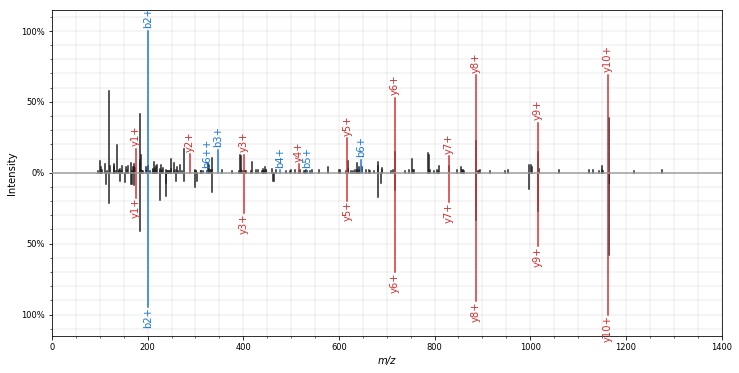

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
sup.mirror(spectrum_bulk,
           spectrum_sc,
           ax=ax)

In [ ]:
import pyteomics.mzml
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from datetime import datetime
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects import pandas2ri

In [8]:
def remove_precursor_peak(df):
    #if there is a peak that is 10X more intense than everything else, get rid of it (it's a precursor that hasn't been fragmented)
    maxpeak = df['intensity'].max()
    
    #if it's ten times more intesne that all the other peaks get rid of it. 
    rm_max_peak = df[df['intensity']!=maxpeak]
    mean_intensity = rm_max_peak['intensity'].nlargest(10).mean()
    
    if maxpeak >= 5*mean_intensity:
        
        #also remove the plusone isotope
        maxmz = df[df['intensity'] == maxpeak]['mz'].values[0]
        plusone = maxmz + 1.0034
        plusone_tol_max = plusone+.01
        plusone_tol_min = plusone-.01
        
        plusonemz_array = rm_max_peak[(rm_max_peak['mz'] <= plusone_tol_max) & (rm_max_peak['mz'] >= plusone_tol_min)]['mz'].values
        if len(plusonemz_array > 0 ): #if there is a plus1 isotope
            plusonemz = plusonemz_array[0]
            rm_max_peak = rm_max_peak[rm_max_peak['mz']!=plusonemz]
        
        return rm_max_peak
    
    return df

def get_dfs(scan1, scan2, mzml1, mzml2):
    spectrum_dict1 = mzml1.get_by_id("controllerType=0 controllerNumber=1 scan="+scan1)
    spectrum_id1 = spectrum_dict1['id']
    mz_array1 = spectrum_dict1['m/z array']
    intensity_array1 = spectrum_dict1['intensity array']
    
    spectrum_dict2 = mzml2.get_by_id("controllerType=0 controllerNumber=1 scan="+scan2)
    spectrum_id2 = spectrum_dict2['id']
    mz_array2 = spectrum_dict2['m/z array']
    intensity_array2 = spectrum_dict2['intensity array']
    
    
    df1 = pd.DataFrame({'mz':mz_array1, 'intensity':intensity_array1 })
    df2 = pd.DataFrame({'mz':mz_array2, 'intensity':intensity_array2 })

    df1 = remove_precursor_peak(df1)
    df2 = remove_precursor_peak(df2)
    
    return df1, df2




In [23]:
def remove_precursor_peak(df):
    #if there is a peak that is 10X more intense than everything else, get rid of it (it's a precursor that hasn't been fragmented)
    maxpeak = df['intensity'].max()
    
    #if it's ten times more intesne that all the other peaks get rid of it. 
    rm_max_peak = df[df['intensity']!=maxpeak]
    mean_intensity = rm_max_peak['intensity'].nlargest(10).mean()
    
    if maxpeak >= 5*mean_intensity:
        
        #also remove the plusone isotope
        maxmz = df[df['intensity'] == maxpeak]['mz'].values[0]
        plusone = maxmz + 1.0034
        plusone_tol_max = plusone+.01
        plusone_tol_min = plusone-.01
        
        plusonemz_array = rm_max_peak[(rm_max_peak['mz'] <= plusone_tol_max) & (rm_max_peak['mz'] >= plusone_tol_min)]['mz'].values
        if len(plusonemz_array > 0 ): #if there is a plus1 isotope
            plusonemz = plusonemz_array[0]
            rm_max_peak = rm_max_peak[rm_max_peak['mz']!=plusonemz]
        
        return rm_max_peak
    
    return df

def get_dfs(scan1, scan2, mzml1, mzml2):
    spectrum_dict1 = mzml1.get_by_id("controllerType=0 controllerNumber=1 scan="+scan1)
    spectrum_id1 = spectrum_dict1['id']
    mz_array1 = spectrum_dict1['m/z array']
    intensity_array1 = spectrum_dict1['intensity array']
    
    spectrum_dict2 = mzml2.get_by_id("controllerType=0 controllerNumber=1 scan="+scan2)
    spectrum_id2 = spectrum_dict2['id']
    mz_array2 = spectrum_dict2['m/z array']
    intensity_array2 = spectrum_dict2['intensity array']
    
    
    df1 = pd.DataFrame({'mz':mz_array1, 'intensity':intensity_array1 })
    df2 = pd.DataFrame({'mz':mz_array2, 'intensity':intensity_array2 })

    df1 = remove_precursor_peak(df1)
    df2 = remove_precursor_peak(df2)
    
    return df1, df2




In [12]:
#get comparisons
all_combos = pd.read_csv('data/list_of_spectra_to_compare/all_combos.tsv', sep='\t')

In [36]:
b_v_2 = all_combos[all_combos['type']=='2ng good vs bulk good']
bv2 = b_v_2[(b_v_2['File1'] =='Ex_Auto_J3_30umTB_2ngQC_60m_1') &(b_v_2['File2'] =='OR11_20160122_PG_HeLa_CVB3_CT_A')]

In [40]:
bv2['peptide_charge'].unique()[20:50]

array(['AADPPAENSSAPEAEQGGAE_2.0', 'AADTIGYPVMIR_2.0',
       'AAEAAAAPAESAAPAAGEEPSKEEGEPK_3.0', 'AAEAAAAPAESAAPAAGEEPSK_2.0',
       'AAEAAAAPAESAAPAAGEEPSK_3.0', 'AAEDDEDDDVDTKK_3.0',
       'AAEDDEDDDVDTK_2.0', 'AAEEIGIK_2.0', 'AAEGVSAADMAK_2.0',
       'AAELETDIR_2.0', 'AAELFVETIAK_2.0', 'AAELIANSLATAGDGLIELR_2.0',
       'AAELIANSLATAGDGLIELR_3.0', 'AAEMMASLLK_2.0',
       'AAFDDAIAELDTLSEESYK_2.0', 'AAFDDAIAELDTLSEESYK_3.0',
       'AAGASDVVLYK_2.0', 'AAGPSLSHTSGGTQSK_3.0', 'AAGTDGSDFQHR_3.0',
       'AAGVVLEMIR_2.0', 'AAHSEGNTTAGLDMR_3.0', 'AAIDWFDGK_2.0',
       'AAIGLLAR_2.0', 'AAIISAEGDSK_2.0', 'AALAHSEEVTASQVAATK_3.0',
       'AALEAQNALHNMK_3.0', 'AALEAVGGTVVLE_2.0', 'AALQELLSK_2.0',
       'AALRPLVK_2.0', 'AALSALESFLK_2.0'], dtype=object)

In [133]:
bv2[bv2['peptide_charge']=='AALEAQNALHNMK_3.0']

,peptide_charge,Scan1,Prob1,File1,Scan2,Prob2,File2,type
362289,AALEAQNALHNMK_3.0,14782,0.006027,Ex_Auto_J3_30umTB_2ngQC_60m_1,31608,0.000011,OR11_20160122_PG_HeLa_CVB3_CT_A,2ng good vs bulk good
362291,AALEAQNALHNMK_3.0,14782,0.006027,Ex_Auto_J3_30umTB_2ngQC_60m_1,31576,0.002239,OR11_20160122_PG_HeLa_CVB3_CT_A,2ng good vs bulk good
362297,AALEAQNALHNMK_3.0,14782,0.006027,Ex_Auto_J3_30umTB_2ngQC_60m_1,31666,0.000537,OR11_20160122_PG_HeLa_CVB3_CT_A,2ng good vs bulk good


In [367]:
bv2.sort_values('Prob1', ascending=False).iloc[500:505]

,peptide_charge,Scan1,Prob1,File1,Scan2,Prob2,File2,type
509141,FYTDPVEAVK_2.0,17840,0.006703,Ex_Auto_J3_30umTB_2ngQC_60m_1,50563,0.000114,OR11_20160122_PG_HeLa_CVB3_CT_A,2ng good vs bulk good
840427,VIHLSNLPHSGYSDSAVLK_4.0,20980,0.006672,Ex_Auto_J3_30umTB_2ngQC_60m_1,58050,0.000000,OR11_20160122_PG_HeLa_CVB3_CT_A,2ng good vs bulk good
840381,VIHLSNLPHSGYSDSAVLK_4.0,20980,0.006672,Ex_Auto_J3_30umTB_2ngQC_60m_1,57923,0.000000,OR11_20160122_PG_HeLa_CVB3_CT_A,2ng good vs bulk good
840437,VIHLSNLPHSGYSDSAVLK_4.0,20980,0.006672,Ex_Auto_J3_30umTB_2ngQC_60m_1,58077,0.000000,OR11_20160122_PG_HeLa_CVB3_CT_A,2ng good vs bulk good
840431,VIHLSNLPHSGYSDSAVLK_4.0,20980,0.006672,Ex_Auto_J3_30umTB_2ngQC_60m_1,58037,0.000000,OR11_20160122_PG_HeLa_CVB3_CT_A,2ng good vs bulk good


In [382]:
def get_spec(my_scan, my_peptide, mzml):
    my_id = 'controllerType=0 controllerNumber=1 scan='+ my_scan
    spectrum_dict = mzml.get_by_id(my_id)
    
    
    spectrum_id = spectrum_dict['id']
    mz_array = spectrum_dict['m/z array']
    intensity_array = spectrum_dict['intensity array']
    retention_time = (spectrum_dict['scanList']['scan'][0].get('scan start time', -1))
    precursor = spectrum_dict['precursorList']['precursor'][0]
    precursor_ion = precursor['selectedIonList']['selectedIon'][0]
    precursor_mz = precursor_ion['selected ion m/z']

    if 'charge state' in precursor_ion:
        precursor_charge = int(precursor_ion['charge state'])
    elif 'possible charge state' in precursor_ion:
        precursor_charge = int(precursor_ion['possible charge state'])
    else:
        raise ValueError('Unknown precursor charge')

    scan_num = spectrum_dict["id"][spectrum_dict["id"].find('scan=') + 5:]
    ms_level = spectrum_dict["ms level"]
    total_ion_curr = spectrum_dict["total ion current"]
    ion_time = spectrum_dict["scanList"]['scan'][0]["ion injection time"]

    spectrum = sus.MsmsSpectrum(spectrum_id, precursor_mz, precursor_charge,
                        mz_array, intensity_array, None, retention_time, peptide=my_peptide)
 
    # Process the MS/MS spectrum.
    fragment_tol_mass = 50
    fragment_tol_mode = 'ppm'    
    spectrum = (spectrum.annotate_peptide_fragments(fragment_tol_mass, fragment_tol_mode,
                                            ion_types='y',max_ion_charge=2))
    
    return spectrum

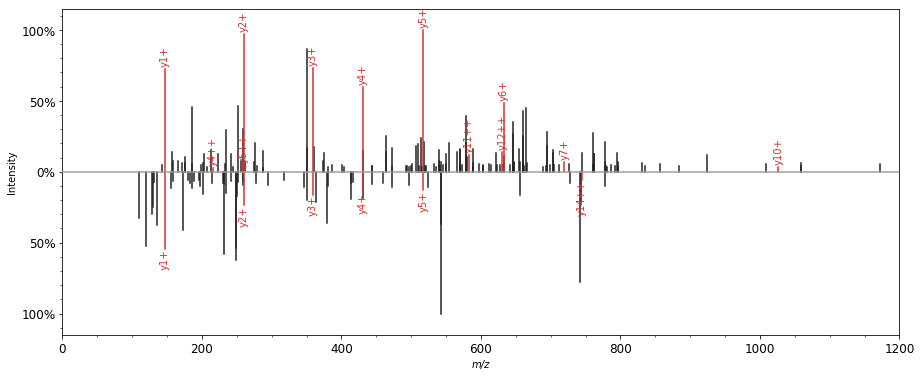

In [383]:
peptide ='VIHLSNLPHSGYSDSAVLK'
spectrum_bulk = get_spec('58050',peptide,mzml_bulk1)
spectrum_sc = get_spec('20980',peptide ,mzml_2ng1)

fig, ax = plt.subplots(figsize=(15, 6))
sup.mirror(spectrum_bulk,
           spectrum_sc,
           ax=ax)
plt.xlim(0, 1200)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.grid(b=False, which='both')
plt.savefig('Figures/TOC_fig.png', dpi=600)
plt.show()

In [388]:
bulk_rep1 = dl.load_joined_psm_mzml('bulk_rep1')[['peptide','scan','minute','Matched Ion Intensities','QValue', 'intensity_array']]

rep1_2ng = dl.load_joined_psm_mzml("2ng_rep1")[['peptide','scan','minute','Matched Ion Intensities','QValue', 'intensity_array']]


In [393]:
b = bulk_rep1[bulk_rep1['scan'] == 58050] 
sc = rep1_2ng[rep1_2ng['scan'] == 20980] 

In [394]:
b

,peptide,scan,minute,Matched Ion Intensities,QValue,intensity_array
19516,VIHLSNLPHSGYSDSAVLK,58050,87,"[b2+1:127148, b3+1:708945, b4+1:205145, b5+1:4...",0.0,"[39103.91796875, 591636.9375, 116235.859375, 6..."


In [395]:
sc

,peptide,scan,minute,Matched Ion Intensities,QValue,intensity_array
13690,VIHLSNLPHSGYSDSAVLK,20980,62,"[b3+1:2362, b7+1:1155];[y1+1:6349, y2+1:2771, ...",0.006672,"[3789.7265625, 6133.8544921875, 3509.210693359..."


In [18]:
# Defining the R script and loading the instance in Python
r = robjects.r
r['source']('calc_cosine_score.R')
SpectrumSimilarity = robjects.globalenv['SpectrumSimilarity']  # Loading the function we have defined in R.


In [25]:
file1_name = 'Ex_Auto_J3_30umTB_2ngQC_60m_1'   
file2_name = 'OR11_20160122_PG_HeLa_CVB3_CT_A'   

file1_path = 'data/mzMLs/'
file1_path = file1_path+file1_name+".mzML"
file1 = pyteomics.mzml.MzML(file1_path)

file2_path = 'data/mzMLs/'
file2_path = file2_path+file2_name+".mzML"
file2 = pyteomics.mzml.MzML(file2_path)

In [381]:
comp_typo = '2ng good vs bulk good'

df1, df2 = get_dfs(str(20980), str(58050), file1, file2)

pandas2ri.activate()
mins = [df1['mz'].min(), df2['mz'].min()]
maxs = [df1['mz'].max(), df2['mz'].max()]
sim_score = SpectrumSimilarity(df1, df2, xlim = [min(mins), max(maxs)])
sim_score = sim_score[0]
sim_score

0.2304596451424824

In [263]:
#possible
peptide ='QLFEEQAK'
spectrum_bulk = get_spec('24293',peptide,mzml_bulk1)
spectrum_sc = get_spec('12365',peptide ,mzml_2ng1)


peptide ='VKPLQDQNELFGK'
spectrum_bulk = get_spec('45710',peptide,mzml_bulk1)
spectrum_sc = get_spec('17962',peptide ,mzml_2ng1)

peptide ='IAENLGDVQISDK'
spectrum_bulk = get_spec('48194',peptide,mzml_bulk1)
spectrum_sc = get_spec('17384',peptide ,mzml_2ng1)

peptide ='EIEYEVVR'
spectrum_bulk = get_spec('37535',peptide,mzml_bulk1)
spectrum_sc = get_spec('14882',peptide ,mzml_2ng1)

peptide ='TLEVEIEPGVR'
spectrum_bulk = get_spec('57791',peptide,mzml_bulk1)
spectrum_sc = get_spec('19808',peptide ,mzml_2ng1)

peptide ='DNIQGITK'
spectrum_bulk = get_spec('13764',peptide,mzml_bulk1)
spectrum_sc = get_spec('9195',peptide ,mzml_2ng1)

peptide ='HRPELIDYGK'
spectrum_bulk = get_spec('20344',peptide,mzml_bulk1)
spectrum_sc = get_spec('12684',peptide ,mzml_2ng1)

peptide ='GLHQSIEEFR'
spectrum_bulk = get_spec('34668',peptide,mzml_bulk1)
spectrum_sc = get_spec('15359',peptide ,mzml_2ng1)


peptide ='IQFKPDDGISPER'
spectrum_bulk = get_spec('38980',peptide,mzml_bulk1)
spectrum_sc = get_spec('15850',peptide ,mzml_2ng1)


peptide ='YDPTIEDSYRK'
spectrum_bulk = get_spec('22005',peptide,mzml_bulk1)
spectrum_sc = get_spec('11227',peptide ,mzml_2ng1)

peptide ='TQILAASYELHK'
spectrum_bulk = get_spec('46335',peptide,mzml_bulk1)
spectrum_sc = get_spec('17680',peptide ,mzml_2ng1)

peptide ='ATIAGGGVIPHIHK'
spectrum_bulk = get_spec('35170',peptide,mzml_bulk1)
spectrum_sc = get_spec('16098',peptide ,mzml_2ng1)

peptide ='ATIAGGGVIPHIHK'
spectrum_bulk = get_spec('35170',peptide,mzml_bulk1)
spectrum_sc = get_spec('16098',peptide ,mzml_2ng1)

peptide ='TDVDVSLPK'
spectrum_bulk = get_spec('38341',peptide,mzml_bulk1)
spectrum_sc = get_spec('15741',peptide ,mzml_2ng1)